In [46]:
# !pip install arch

In [47]:
import pandas as pd
from sklearn.metrics import mean_squared_error
import warnings
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.api import VAR

# Ignorar todos los warnings
warnings.filterwarnings("ignore")

In [48]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Load the data and set the date column as index
date_col = 'date'
df = pd.read_excel('dataframe.xlsx') #SI SE QUIERE PROBAR CON RECESIONES PASADAS, PROBAR CON DATAFRAMES HASTA FECHAS ANTERIORES
df[date_col] = pd.to_datetime(df[date_col])
df.set_index(date_col, inplace=True)

# Normalize the DataFrame except for the 'date' column
scaler = MinMaxScaler()
columns_to_normalize = df.columns.difference(['date', 'USREC'])  # Exclude the 'date' and 'USREC' column
df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])

df.head(5)


,VIX,Unemployment,Interest_Rates,YIC,M2 MONEY STOCK,PER CAPITA CONSUMPTION,CONSUMER PRICE INDEX,USREC
date,,,,,,,,
1990-01-01,0.251618,0.175439,0.992718,0.279255,0.000000,0.000000,0.000000,0
1990-02-01,0.249905,0.166667,0.993932,0.273936,0.000668,0.004565,0.003214,0
1990-03-01,0.188999,0.157895,0.998786,0.236702,0.001256,0.009115,0.006964,0
1990-04-01,0.214503,0.175439,0.996359,0.263298,0.001875,0.011946,0.008036,0
1990-05-01,0.151694,0.175439,0.986650,0.279255,0.001822,0.014857,0.009643,0


### Step 2: Forecast VIX using GARCH

In [49]:
import pandas as pd
from arch import arch_model
import numpy as np

# Ensure no NaN or inf values in the VIX data
vix_returns = df['VIX'].pct_change().dropna()
vix_returns = vix_returns[np.isfinite(vix_returns)]

# Fit GARCH model for VIX
model_garch_vix = arch_model(vix_returns, vol='Garch', p=1, q=1)
model_garch_vix_fitted = model_garch_vix.fit(disp='off')

# Forecast 12, 24, and 36 months
forecast_garch_vix_12 = model_garch_vix_fitted.forecast(horizon=12)
forecast_garch_vix_24 = model_garch_vix_fitted.forecast(horizon=24)
forecast_garch_vix_36 = model_garch_vix_fitted.forecast(horizon=36)

# Extract the mean forecast and reformat the DataFrame
forecast_garch_vix_12_mean = forecast_garch_vix_12.mean.values[-1, :]
forecast_garch_vix_24_mean = forecast_garch_vix_24.mean.values[-1, :]
forecast_garch_vix_36_mean = forecast_garch_vix_36.mean.values[-1, :]

forecast_garch_vix_12_df = pd.DataFrame(forecast_garch_vix_12_mean, index=pd.date_range(start=df.index[-1], periods=12, freq='M'), columns=['VIX'])
forecast_garch_vix_24_df = pd.DataFrame(forecast_garch_vix_24_mean, index=pd.date_range(start=df.index[-1], periods=24, freq='M'), columns=['VIX'])
forecast_garch_vix_36_df = pd.DataFrame(forecast_garch_vix_36_mean, index=pd.date_range(start=df.index[-1], periods=36, freq='M'), columns=['VIX'])

# Invert the percentage change transformation
last_value = df['VIX'].iloc[-1]
forecast_garch_vix_12_df = last_value * (1 + forecast_garch_vix_12_df).cumprod()
forecast_garch_vix_24_df = last_value * (1 + forecast_garch_vix_24_df).cumprod()
forecast_garch_vix_36_df = last_value * (1 + forecast_garch_vix_36_df).cumprod()

# Combine historical data with forecasted data
combined_vix_12_df = pd.concat([df[['VIX']], forecast_garch_vix_12_df])
combined_vix_24_df = pd.concat([df[['VIX']], forecast_garch_vix_24_df])
combined_vix_36_df = pd.concat([df[['VIX']], forecast_garch_vix_36_df])

print(combined_vix_12_df.head())
print(combined_vix_24_df.head())
print(combined_vix_36_df.head())



                 VIX
1990-01-01  0.251618
1990-02-01  0.249905
1990-03-01  0.188999
1990-04-01  0.214503
1990-05-01  0.151694
                 VIX
1990-01-01  0.251618
1990-02-01  0.249905
1990-03-01  0.188999
1990-04-01  0.214503
1990-05-01  0.151694
                 VIX
1990-01-01  0.251618
1990-02-01  0.249905
1990-03-01  0.188999
1990-04-01  0.214503
1990-05-01  0.151694


### Step 3: Forecast Unemployment using ARIMA

In [50]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA

# Ensure the Unemployment data is stationary
unemployment_diff = df[['Unemployment']].diff().dropna()

# Fit ARIMA model for Unemployment
model_arima_unemployment = ARIMA(unemployment_diff, order=(1,1,1))
model_arima_unemployment_fitted = model_arima_unemployment.fit()

# Forecast 12, 24, and 36 months
forecast_arima_unemployment_diff_12 = model_arima_unemployment_fitted.forecast(steps=12)
forecast_arima_unemployment_diff_24 = model_arima_unemployment_fitted.forecast(steps=24)
forecast_arima_unemployment_diff_36 = model_arima_unemployment_fitted.forecast(steps=36)

# Function to invert differencing
def invert_transformation(df, forecast_diff, column):
    forecast = []
    last_value = df[column].iloc[-1]
    for diff_value in forecast_diff:
        forecast_value = last_value + diff_value
        forecast.append(forecast_value)
        last_value = forecast_value
    return forecast

# Convert the differenced forecast to the original scale
forecast_arima_unemployment_12 = invert_transformation(df, forecast_arima_unemployment_diff_12, 'Unemployment')
forecast_arima_unemployment_24 = invert_transformation(df, forecast_arima_unemployment_diff_24, 'Unemployment')
forecast_arima_unemployment_36 = invert_transformation(df, forecast_arima_unemployment_diff_36, 'Unemployment')

# Convert forecasts to DataFrame
forecast_arima_unemployment_12_df = pd.DataFrame(forecast_arima_unemployment_12, index=pd.date_range(start=df.index[-1], periods=12, freq='M'), columns=['Unemployment'])
forecast_arima_unemployment_24_df = pd.DataFrame(forecast_arima_unemployment_24, index=pd.date_range(start=df.index[-1], periods=24, freq='M'), columns=['Unemployment'])
forecast_arima_unemployment_36_df = pd.DataFrame(forecast_arima_unemployment_36, index=pd.date_range(start=df.index[-1], periods=36, freq='M'), columns=['Unemployment'])

print("ARIMA Model 12-Month Forecast for Unemployment:")
print(forecast_arima_unemployment_12_df.head())
print("ARIMA Model 24-Month Forecast for Unemployment:")
print(forecast_arima_unemployment_24_df.head())
print("ARIMA Model 36-Month Forecast for Unemployment:")
print(forecast_arima_unemployment_36_df.head())



ARIMA Model 12-Month Forecast for Unemployment:
            Unemployment
2024-05-31      0.052525
2024-06-30      0.052231
2024-07-31      0.051933
2024-08-31      0.051635
2024-09-30      0.051337
ARIMA Model 24-Month Forecast for Unemployment:
            Unemployment
2024-05-31      0.052525
2024-06-30      0.052231
2024-07-31      0.051933
2024-08-31      0.051635
2024-09-30      0.051337
ARIMA Model 36-Month Forecast for Unemployment:
            Unemployment
2024-05-31      0.052525
2024-06-30      0.052231
2024-07-31      0.051933
2024-08-31      0.051635
2024-09-30      0.051337


### Step 4: Forecast Interest Rates using ARIMA

In [51]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import numpy as np

# Print column names to ensure 'Interest_Rates' exists
print("Columns in the dataframe:", df.columns)

# Ensure no NaN or inf values in the Interest Rates data
if 'Interest_Rates' in df.columns:
    interest_rates = df['Interest_Rates'].dropna()
    print("Interest Rates data:")
    print(interest_rates.head())
else:
    raise KeyError("The column 'Interest_Rates' does not exist in the dataframe.")

# Check if differencing is required to achieve stationarity
interest_rates_diff = interest_rates.diff().dropna()
print("Differenced Interest Rates data:")
print(interest_rates_diff.head())

# Fit ARIMA model for Interest Rates
model_arima_interest_rates = ARIMA(interest_rates_diff, order=(1, 1, 1))
model_arima_interest_rates_fitted = model_arima_interest_rates.fit()

# Forecast 12, 24, and 36 months
forecast_arima_interest_rates_diff_12 = model_arima_interest_rates_fitted.forecast(steps=12)
forecast_arima_interest_rates_diff_24 = model_arima_interest_rates_fitted.forecast(steps=24)
forecast_arima_interest_rates_diff_36 = model_arima_interest_rates_fitted.forecast(steps=36)

# Convert the differenced forecast to the original scale
def invert_transformation(df, forecast_diff, column):
    forecast = []
    last_value = df.iloc[-1]  # Use the last value directly
    for diff_value in forecast_diff:
        forecast_value = last_value + diff_value
        forecast.append(forecast_value)
        last_value = forecast_value
    return forecast

forecast_arima_interest_rates_12 = invert_transformation(interest_rates, forecast_arima_interest_rates_diff_12, 'Interest_Rates')
forecast_arima_interest_rates_24 = invert_transformation(interest_rates, forecast_arima_interest_rates_diff_24, 'Interest_Rates')
forecast_arima_interest_rates_36 = invert_transformation(interest_rates, forecast_arima_interest_rates_diff_36, 'Interest_Rates')

# Convert forecasts to DataFrame
last_date = interest_rates.index[-1]
forecast_arima_interest_rates_12_df = pd.DataFrame(forecast_arima_interest_rates_12, index=pd.date_range(start=last_date + pd.DateOffset(months=1), periods=12, freq='M'), columns=['Interest_Rates'])
forecast_arima_interest_rates_24_df = pd.DataFrame(forecast_arima_interest_rates_24, index=pd.date_range(start=last_date + pd.DateOffset(months=1), periods=24, freq='M'), columns=['Interest_Rates'])
forecast_arima_interest_rates_36_df = pd.DataFrame(forecast_arima_interest_rates_36, index=pd.date_range(start=last_date + pd.DateOffset(months=1), periods=36, freq='M'), columns=['Interest_Rates'])

# Print the forecasts
print("ARIMA Model 12-Month Forecast for Interest Rates:")
print(forecast_arima_interest_rates_12_df.head())
print("ARIMA Model 24-Month Forecast for Interest Rates:")
print(forecast_arima_interest_rates_24_df.head())
print("ARIMA Model 36-Month Forecast for Interest Rates:")
print(forecast_arima_interest_rates_36_df.head())


Columns in the dataframe: Index(['VIX', 'Unemployment', 'Interest_Rates', 'YIC', 'M2 MONEY STOCK',
       'PER CAPITA CONSUMPTION', 'CONSUMER PRICE INDEX', 'USREC'],
      dtype='object')
Interest Rates data:
date
1990-01-01    0.992718
1990-02-01    0.993932
1990-03-01    0.998786
1990-04-01    0.996359
1990-05-01    0.986650
Name: Interest_Rates, dtype: float64
Differenced Interest Rates data:
date
1990-02-01    0.001214
1990-03-01    0.004854
1990-04-01   -0.002427
1990-05-01   -0.009709
1990-06-01    0.013350
Name: Interest_Rates, dtype: float64
ARIMA Model 12-Month Forecast for Interest Rates:
            Interest_Rates
2024-06-30        0.642025
2024-07-31        0.643652
2024-08-31        0.645395
2024-09-30        0.647172
2024-10-31        0.648959
ARIMA Model 24-Month Forecast for Interest Rates:
            Interest_Rates
2024-06-30        0.642025
2024-07-31        0.643652
2024-08-31        0.645395
2024-09-30        0.647172
2024-10-31        0.648959
ARIMA Model 36-Month

### Step 5: Forecast YIC using LSTM

In [52]:
# !pip install tensorflow

In [53]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Function to create dataset for LSTM
def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data) - time_step - 1):
        a = data[i:(i + time_step), 0]
        X.append(a)
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

# Normalize the data for YIC using a separate scaler
scaler_yic = MinMaxScaler()
scaled_yic = scaler_yic.fit_transform(df[['YIC']].values)
X, Y = create_dataset(scaled_yic, time_step=12)
X = X.reshape(X.shape[0], X.shape[1], 1)
X_train, Y_train = X[:int(len(X) * 0.8)], Y[:int(len(X) * 0.8)]

# Build and train LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(50, return_sequences=True, input_shape=(12, 1)))
model_lstm.add(LSTM(50, return_sequences=False))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer='adam', loss='mean_squared_error')
model_lstm.fit(X_train, Y_train, epochs=100, batch_size=32, verbose=1)

# Function to predict LSTM
def predict_lstm(model, data, scaler, time_step, forecast_period):
    forecast = []
    input_seq = data[-time_step:]
    for _ in range(forecast_period):
        input_seq = input_seq.reshape((1, time_step, 1))
        prediction = model.predict(input_seq)
        forecast.append(prediction[0, 0])
        input_seq = np.append(input_seq[:, 1:, :], prediction).reshape(time_step, 1)
    forecast = scaler.inverse_transform(np.array(forecast).reshape(-1, 1))
    return forecast

# Make predictions for 12, 24, and 36 months
forecast_lstm_12 = predict_lstm(model_lstm, scaled_yic, scaler_yic, 12, 12)
forecast_lstm_24 = predict_lstm(model_lstm, scaled_yic, scaler_yic, 12, 24)
forecast_lstm_36 = predict_lstm(model_lstm, scaled_yic, scaler_yic, 12, 36)

# Convert forecasts to DataFrame
forecast_lstm_12_df = pd.DataFrame(forecast_lstm_12, index=pd.date_range(start=df.index[-1], periods=12, freq='M'), columns=['YIC'])
forecast_lstm_24_df = pd.DataFrame(forecast_lstm_24, index=pd.date_range(start=df.index[-1], periods=24, freq='M'), columns=['YIC'])
forecast_lstm_36_df = pd.DataFrame(forecast_lstm_36, index=pd.date_range(start=df.index[-1], periods=36, freq='M'), columns=['YIC'])

print("LSTM Model 12-Month Forecast for YIC:")
print(forecast_lstm_12_df.head())


Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.2994
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0343 
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0201 
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0168 
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0151 
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0142 
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0142 
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0131 
Epoch 9/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0125 
Epoch 10/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0117 
Epoch 11/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0123 
Epoch 12/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0104 
Epoch 13/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0100 
Epoch 14/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0108 
Epoch 15/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss

### 6. M2 MONEY STOCK

In [54]:
from prophet import Prophet
import pandas as pd

# Prepare data for Prophet
df_prophet = df[['M2 MONEY STOCK']].reset_index()
df_prophet.columns = ['ds', 'y']

# Fit Prophet model
model_prophet = Prophet()
model_prophet.fit(df_prophet)

# Forecast 12, 24, and 36 months
future_12 = model_prophet.make_future_dataframe(periods=12, freq='M')
forecast_prophet_12 = model_prophet.predict(future_12)
forecast_prophet_12 = forecast_prophet_12[['ds', 'yhat']].set_index('ds').iloc[-12:]

future_24 = model_prophet.make_future_dataframe(periods=24, freq='M')
forecast_prophet_24 = model_prophet.predict(future_24)
forecast_prophet_24 = forecast_prophet_24[['ds', 'yhat']].set_index('ds').iloc[-24:]

future_36 = model_prophet.make_future_dataframe(periods=36, freq='M')
forecast_prophet_36 = model_prophet.predict(future_36)
forecast_prophet_36 = forecast_prophet_36[['ds', 'yhat']].set_index('ds').iloc[-36:]

# Convert forecasts to DataFrame
forecast_prophet_12_df = pd.DataFrame(forecast_prophet_12)
forecast_prophet_12_df.columns = ['M2 MONEY STOCK']
forecast_prophet_24_df = pd.DataFrame(forecast_prophet_24)
forecast_prophet_24_df.columns = ['M2 MONEY STOCK']
forecast_prophet_36_df = pd.DataFrame(forecast_prophet_36)
forecast_prophet_36_df.columns = ['M2 MONEY STOCK']

# Print the forecasts
print("Prophet Model 12-Month Forecast for M2 MONEY STOCK:")
print(forecast_prophet_12_df.head())
print("Prophet Model 24-Month Forecast for M2 MONEY STOCK:")
print(forecast_prophet_24_df.head())
print("Prophet Model 36-Month Forecast for M2 MONEY STOCK:")
print(forecast_prophet_36_df.head())


23:14:50 - cmdstanpy - INFO - Chain [1] start processing
23:14:50 - cmdstanpy - INFO - Chain [1] done processing


Prophet Model 12-Month Forecast for M2 MONEY STOCK:
            M2 MONEY STOCK
ds                        
2024-05-31        1.056446
2024-06-30        1.065915
2024-07-31        1.075952
2024-08-31        1.083775
2024-09-30        1.090272
Prophet Model 24-Month Forecast for M2 MONEY STOCK:
            M2 MONEY STOCK
ds                        
2024-05-31        1.056446
2024-06-30        1.065915
2024-07-31        1.075952
2024-08-31        1.083775
2024-09-30        1.090272
Prophet Model 36-Month Forecast for M2 MONEY STOCK:
            M2 MONEY STOCK
ds                        
2024-05-31        1.056446
2024-06-30        1.065915
2024-07-31        1.075952
2024-08-31        1.083775
2024-09-30        1.090272


### 7. PER CAPITA CONSUMPTION

In [55]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA

# Ensure the PER CAPITA CONSUMPTION data is stationary
per_capita_consumption_diff = df[['PER CAPITA CONSUMPTION']].diff().dropna()

# Fit ARIMA model for PER CAPITA CONSUMPTION
model_arima_pcc = ARIMA(per_capita_consumption_diff, order=(1, 1, 1))
model_arima_pcc_fitted = model_arima_pcc.fit()

# Forecast 12, 24, and 36 months
forecast_arima_pcc_diff_12 = model_arima_pcc_fitted.forecast(steps=12)
forecast_arima_pcc_diff_24 = model_arima_pcc_fitted.forecast(steps=24)
forecast_arima_pcc_diff_36 = model_arima_pcc_fitted.forecast(steps=36)

# Function to invert differencing
def invert_transformation(df, forecast_diff, column):
    forecast = []
    last_value = df[column].iloc[-1]
    for diff_value in forecast_diff:
        forecast_value = last_value + diff_value
        forecast.append(forecast_value)
        last_value = forecast_value
    return forecast

# Convert the differenced forecast to the original scale
forecast_arima_pcc_12 = invert_transformation(df, forecast_arima_pcc_diff_12, 'PER CAPITA CONSUMPTION')
forecast_arima_pcc_24 = invert_transformation(df, forecast_arima_pcc_diff_24, 'PER CAPITA CONSUMPTION')
forecast_arima_pcc_36 = invert_transformation(df, forecast_arima_pcc_diff_36, 'PER CAPITA CONSUMPTION')

# Convert forecasts to DataFrame
forecast_arima_pcc_12_df = pd.DataFrame(forecast_arima_pcc_12, index=pd.date_range(start=df.index[-1] + pd.DateOffset(months=1), periods=12, freq='M'), columns=['PER CAPITA CONSUMPTION'])
forecast_arima_pcc_24_df = pd.DataFrame(forecast_arima_pcc_24, index=pd.date_range(start=df.index[-1] + pd.DateOffset(months=1), periods=24, freq='M'), columns=['PER CAPITA CONSUMPTION'])
forecast_arima_pcc_36_df = pd.DataFrame(forecast_arima_pcc_36, index=pd.date_range(start=df.index[-1] + pd.DateOffset(months=1), periods=36, freq='M'), columns=['PER CAPITA CONSUMPTION'])

# Print the forecasts
print("ARIMA Model 12-Month Forecast for PER CAPITA CONSUMPTION:")
print(forecast_arima_pcc_12_df.head())
print("ARIMA Model 24-Month Forecast for PER CAPITA CONSUMPTION:")
print(forecast_arima_pcc_24_df.head())
print("ARIMA Model 36-Month Forecast for PER CAPITA CONSUMPTION:")
print(forecast_arima_pcc_36_df.head())


ARIMA Model 12-Month Forecast for PER CAPITA CONSUMPTION:
            PER CAPITA CONSUMPTION
2024-06-30                1.003872
2024-07-31                1.008148
2024-08-31                1.012496
2024-09-30                1.016857
2024-10-31                1.021220
ARIMA Model 24-Month Forecast for PER CAPITA CONSUMPTION:
            PER CAPITA CONSUMPTION
2024-06-30                1.003872
2024-07-31                1.008148
2024-08-31                1.012496
2024-09-30                1.016857
2024-10-31                1.021220
ARIMA Model 36-Month Forecast for PER CAPITA CONSUMPTION:
            PER CAPITA CONSUMPTION
2024-06-30                1.003872
2024-07-31                1.008148
2024-08-31                1.012496
2024-09-30                1.016857
2024-10-31                1.021220


### 8. CONSUMER PRICE INDEX

In [56]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA

# Ensure the CONSUMER PRICE INDEX data is stationary
cpi_diff = df[['CONSUMER PRICE INDEX']].diff().dropna()

# Fit ARIMA model for CONSUMER PRICE INDEX
model_arima_cpi = ARIMA(cpi_diff, order=(1, 1, 1))
model_arima_cpi_fitted = model_arima_cpi.fit()

# Forecast 12, 24, and 36 months
forecast_arima_cpi_diff_12 = model_arima_cpi_fitted.forecast(steps=12)
forecast_arima_cpi_diff_24 = model_arima_cpi_fitted.forecast(steps=24)
forecast_arima_cpi_diff_36 = model_arima_cpi_fitted.forecast(steps=36)

# Function to invert differencing
def invert_transformation(df, forecast_diff, column):
    forecast = []
    last_value = df[column].iloc[-1]
    for diff_value in forecast_diff:
        forecast_value = last_value + diff_value
        forecast.append(forecast_value)
        last_value = forecast_value
    return forecast

# Convert the differenced forecast to the original scale
forecast_arima_cpi_12 = invert_transformation(df, forecast_arima_cpi_diff_12, 'CONSUMER PRICE INDEX')
forecast_arima_cpi_24 = invert_transformation(df, forecast_arima_cpi_diff_24, 'CONSUMER PRICE INDEX')
forecast_arima_cpi_36 = invert_transformation(df, forecast_arima_cpi_diff_36, 'CONSUMER PRICE INDEX')

# Convert forecasts to DataFrame
forecast_arima_cpi_12_df = pd.DataFrame(forecast_arima_cpi_12, index=pd.date_range(start=df.index[-1] + pd.DateOffset(months=1), periods=12, freq='M'), columns=['CONSUMER PRICE INDEX'])
forecast_arima_cpi_24_df = pd.DataFrame(forecast_arima_cpi_24, index=pd.date_range(start=df.index[-1] + pd.DateOffset(months=1), periods=24, freq='M'), columns=['CONSUMER PRICE INDEX'])
forecast_arima_cpi_36_df = pd.DataFrame(forecast_arima_cpi_36, index=pd.date_range(start=df.index[-1] + pd.DateOffset(months=1), periods=36, freq='M'), columns=['CONSUMER PRICE INDEX'])

# Print the forecasts
print("ARIMA Model 12-Month Forecast for CONSUMER PRICE INDEX:")
print(forecast_arima_cpi_12_df.head())
print("ARIMA Model 24-Month Forecast for CONSUMER PRICE INDEX:")
print(forecast_arima_cpi_24_df.head())
print("ARIMA Model 36-Month Forecast for CONSUMER PRICE INDEX:")
print(forecast_arima_cpi_36_df.head())


ARIMA Model 12-Month Forecast for CONSUMER PRICE INDEX:
            CONSUMER PRICE INDEX
2024-06-30              1.003278
2024-07-31              1.006898
2024-08-31              1.010761
2024-09-30              1.014793
2024-10-31              1.018946
ARIMA Model 24-Month Forecast for CONSUMER PRICE INDEX:
            CONSUMER PRICE INDEX
2024-06-30              1.003278
2024-07-31              1.006898
2024-08-31              1.010761
2024-09-30              1.014793
2024-10-31              1.018946
ARIMA Model 36-Month Forecast for CONSUMER PRICE INDEX:
            CONSUMER PRICE INDEX
2024-06-30              1.003278
2024-07-31              1.006898
2024-08-31              1.010761
2024-09-30              1.014793
2024-10-31              1.018946


### Step 6: Combine Forecasts

In [57]:
# Combine actual and forecast data for each variable
def combine_forecast(df, forecast_df, column):
    combined_df = pd.concat([df[[column]], forecast_df])
    return combined_df

# Create new DataFrames for the combined data
combined_forecast_12_df = pd.concat([df, pd.DataFrame(index=pd.date_range(start=df.index[-1] + pd.DateOffset(months=1), periods=12, freq='M'))])
combined_forecast_24_df = pd.concat([df, pd.DataFrame(index=pd.date_range(start=df.index[-1] + pd.DateOffset(months=1), periods=24, freq='M'))])
combined_forecast_36_df = pd.concat([df, pd.DataFrame(index=pd.date_range(start=df.index[-1] + pd.DateOffset(months=1), periods=36, freq='M'))])

print("Combining forecasts...")

for column in df.columns:
    print(f"Processing column: {column}")
    if column == 'YIC':
        combined_forecast_12_df[column].iloc[-12:] = forecast_lstm_12_df.values.flatten()
        combined_forecast_24_df[column].iloc[-24:] = forecast_lstm_24_df.values.flatten()
        combined_forecast_36_df[column].iloc[-36:] = forecast_lstm_36_df.values.flatten()
    elif column == 'M2 MONEY STOCK':
        combined_forecast_12_df[column].iloc[-12:] = forecast_prophet_12_df.values.flatten()
        combined_forecast_24_df[column].iloc[-24:] = forecast_prophet_24_df.values.flatten()
        combined_forecast_36_df[column].iloc[-36:] = forecast_prophet_36_df.values.flatten()
    elif column == 'PER CAPITA CONSUMPTION':
        combined_forecast_12_df[column].iloc[-12:] = forecast_arima_pcc_12_df.values.flatten()
        combined_forecast_24_df[column].iloc[-24:] = forecast_arima_pcc_24_df.values.flatten()
        combined_forecast_36_df[column].iloc[-36:] = forecast_arima_pcc_36_df.values.flatten()
    elif column == 'CONSUMER PRICE INDEX':
        combined_forecast_12_df[column].iloc[-12:] = forecast_arima_cpi_12_df.values.flatten()
        combined_forecast_24_df[column].iloc[-24:] = forecast_arima_cpi_24_df.values.flatten()
        combined_forecast_36_df[column].iloc[-36:] = forecast_arima_cpi_36_df.values.flatten()
    elif column == 'VIX':
        combined_forecast_12_df[column].iloc[-12:] = forecast_garch_vix_12_df.values.flatten()
        combined_forecast_24_df[column].iloc[-24:] = forecast_garch_vix_24_df.values.flatten()
        combined_forecast_36_df[column].iloc[-36:] = forecast_garch_vix_36_df.values.flatten()
    elif column == 'Unemployment':
        combined_forecast_12_df[column].iloc[-12:] = forecast_arima_unemployment_12_df.values.flatten()
        combined_forecast_24_df[column].iloc[-24:] = forecast_arima_unemployment_24_df.values.flatten()
        combined_forecast_36_df[column].iloc[-36:] = forecast_arima_unemployment_36_df.values.flatten()
    elif column == 'Interest_Rates':
        combined_forecast_12_df[column].iloc[-12:] = forecast_arima_interest_rates_12_df.values.flatten()
        combined_forecast_24_df[column].iloc[-24:] = forecast_arima_interest_rates_24_df.values.flatten()
        combined_forecast_36_df[column].iloc[-36:] = forecast_arima_interest_rates_36_df.values.flatten()



Combining forecasts...
Processing column: VIX
Processing column: Unemployment
Processing column: Interest_Rates
Processing column: YIC
Processing column: M2 MONEY STOCK
Processing column: PER CAPITA CONSUMPTION
Processing column: CONSUMER PRICE INDEX
Processing column: USREC


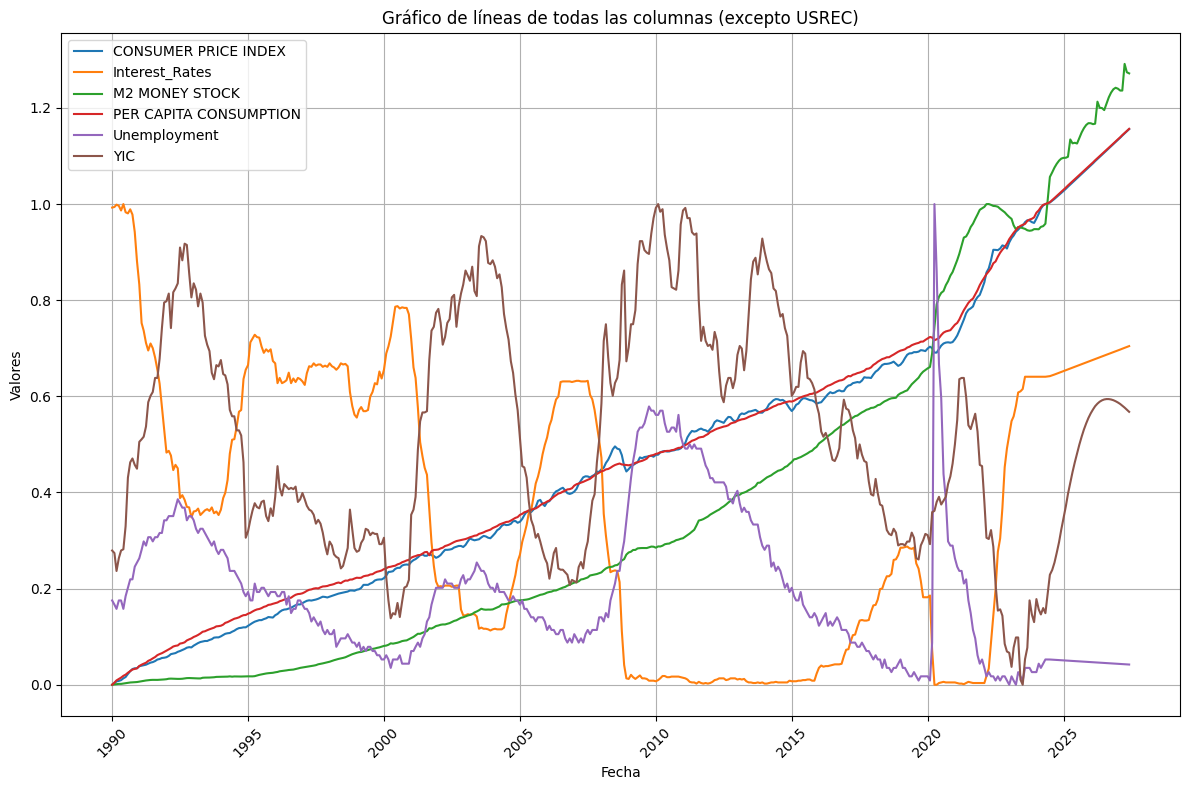

In [58]:
import matplotlib.pyplot as plt

# Excluir la columna 'USREC'
columns_to_plot = combined_forecast_36_df.columns.difference(['USREC', 'VIX'])

# Crear el gráfico de líneas para cada columna
plt.figure(figsize=(12, 8)) 

for column in columns_to_plot:
    plt.plot(combined_forecast_36_df.index, combined_forecast_36_df[column], label=column)

# Personalizar etiquetas y título
plt.xlabel('Fecha')
plt.ylabel('Valores')
plt.title('Gráfico de líneas de todas las columnas (excepto USREC)')

# Mostrar el gráfico
plt.grid(True)  # Mostrar cuadrícula
plt.xticks(rotation=45)  # Rotar etiquetas del eje x 
plt.legend()  # Mostrar leyenda

plt.tight_layout()  # Ajustar el diseño
plt.show()

In [59]:
# Filtrar los últimos 36 valores
df_filtered = combined_forecast_36_df.tail(36)

In [60]:
df_filtered.to_excel('36_months.xlsx')